## Group 8: Machine Learning - Based Stock Price Prediction
### Yuting Shao (shao.yut@northeastern.edu)
**Objective:** Develop a machine learning model to predict future stock prices with a high degree of accuracy, based on close prices of a historical window. Use mean squared error (MSE) as evaluation metrics. Use the LSTM and GRUmachine learning model. TensorFlow and scikit-learn will be used.

### 1. Collect and preprocess the data

In [283]:
import yfinance as yf
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns
import os
import json
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, GRU, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [284]:
# set a seed for reproducible results
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# set the figure style using Seaborn
sns.set(style="whitegrid", context="paper")

In [285]:
class StockDataPreprocessor:
    """
    A class to preprocess stock data fetched from Yahoo Finance.
    """

    def __init__(self, stock_symbol, start_date, end_date):
        """
        Initializes a StockDataPreprocessor object.

        Args:
            stock_symbol (str): The stock symbol to fetch data for.
            start_date (str): The start date for fetching stock data in YYYY-MM-DD format.
            end_date (str): The end date for fetching stock data in YYYY-MM-DD format.
        """
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.stock_data = None

    def fetch_data(self):
        """
        Fetches historical stock price data from Yahoo Finance.
        """
        self.stock_data = yf.download(self.stock_symbol, start=self.start_date, end=self.end_date)

    def preprocess(self):
        """
        Preprocesses the fetched stock data by handling missing values, resampling the data,
        and resetting the index.
        """
        self.stock_data.fillna(method='ffill', inplace=True)
        self.stock_data.fillna(method='bfill', inplace=True)
        self.stock_data = self.stock_data.dropna()
        self.stock_data = self.stock_data.resample('B').mean()
        self.stock_data.fillna(method='ffill', inplace=True)
        self.stock_data.fillna(method='bfill', inplace=True)
        self.stock_data = self.stock_data.dropna()
        self.stock_data.reset_index(inplace=True)

    def compute_features(self):
        """
        Computes additional features for the preprocessed stock data, including returns
        and the previous day's volume.
        """
        self.stock_data['Returns'] = self.stock_data['Close'].pct_change()
        self.stock_data['Prev_Volume'] = self.stock_data['Volume'].shift(1)
        self.stock_data.dropna(inplace=True)

    def save_to_csv(self):
        """
        Saves the preprocessed stock data to a CSV file.
        """
        self.stock_data.to_csv(f"{self.stock_symbol}_preprocessed_data.csv", index=False)

    def process(self):
        """
        Executes the entire data processing pipeline by fetching data, preprocessing,
        computing features, and saving the data to a CSV file.
        """
        self.fetch_data()
        self.preprocess()
        self.compute_features()
        self.save_to_csv()

In [286]:
stock_symbol = 'AAPL'
start_date = '2002-01-01'
end_date = '2022-12-31'
preprocessor = StockDataPreprocessor(stock_symbol, start_date, end_date)
preprocessor.process()
print(preprocessor.stock_data.head())

[*********************100%***********************]  1 of 1 completed
        Date      Open      High       Low     Close  Adj Close       Volume  \
1 2002-01-03  0.410714  0.424107  0.406607  0.421071   0.358381  612007200.0   
2 2002-01-04  0.416786  0.427679  0.410536  0.423036   0.360054  409976000.0   
3 2002-01-07  0.423571  0.428571  0.406250  0.408929   0.348047  444584000.0   
4 2002-01-08  0.406250  0.411607  0.401071  0.403750   0.343639  450038400.0   
5 2002-01-09  0.407143  0.409464  0.380000  0.386607   0.329048  327835200.0   

    Returns  Prev_Volume  
1  0.012017  529496800.0  
2  0.004667  612007200.0  
3 -0.033347  409976000.0  
4 -0.012665  444584000.0  
5 -0.042459  450038400.0  


### 2. Analysis of input and target variables

In [287]:
class StockDataAnalysis:
    """
    A class to perform data analysis and visualization on preprocessed stock data.
    """

    def __init__(self, stock_data, stock_symbol):
        """
        Initializes a StockDataAnalysis object.

        Args:
            stock_data (pd.DataFrame): The preprocessed stock data to analyze.
            stock_symbol (str): The stock symbol to use in plot titles.
        """
        self.stock_data = stock_data
        self.stock_symbol = stock_symbol

    def display_statistics(self):
        """
        Displays descriptive statistics for the input and target variables.
        """
        print("Stock Price Statistics:\n", self.stock_data['Close'].describe())
        print("\nTrading Volume Statistics:\n", self.stock_data['Volume'].describe())
        print("\nReturns Statistics:\n", self.stock_data['Returns'].describe())

    def plot_histograms(self):
        """
        Plots histograms for the input and target variables.
        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        sns.histplot(self.stock_data['Close'], kde=True, ax=axes[0]).set(title='Stock Price Distribution')
        sns.histplot(self.stock_data['Volume'], kde=True, ax=axes[1]).set(title='Trading Volume Distribution')
        sns.histplot(self.stock_data['Returns'].dropna(), kde=True, ax=axes[2]).set(title='Returns Distribution')
        plt.savefig('histgrams.png', dpi=600)
        plt.show()

    def plot_stock_price(self):
        """
        Plots a line plot of the stock price over time.
        """
        plt.figure(figsize=(14, 6))
        plt.plot(self.stock_data.index, self.stock_data['Close'], label='Stock Price', color='blue')
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.title(f"{self.stock_symbol} Stock Price Over Time")
        plt.savefig('price.png', dpi=600)
        plt.show()

    def plot_correlation_heatmap(self):
        """
        Computes and plots a correlation heatmap for the input and target variables.
        """
        correlation_matrix = self.stock_data[['Close', 'Volume', 'Returns']].corr()
        print("\nCorrelation Matrix:\n", correlation_matrix)
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title("Correlation Heatmap")
        plt.savefig('corr.png', dpi=600)
        plt.show()

    def plot_scatter_plots(self):
        """
        Plots scatter plots for the input variables against the target variable.
        """
        volume_aligned = self.stock_data['Volume'][:]
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].scatter(self.stock_data['Volume'], self.stock_data['Close'])
        axes[0].set(title='Stock Price vs. Trading Volume', xlabel='Trading Volume', ylabel='Stock Price')
        axes[1].scatter(volume_aligned, self.stock_data['Returns'].dropna())
        axes[1].set(title='Returns vs. Trading Volume', xlabel='Trading Volume', ylabel='Returns')
        plt.savefig('scatter.png', dpi=600)
        plt.show()

    def plot_autocorrelation(self):
        """
        Plots autocorrelation plots for the stock price, trading volume, and returns.
        """
        plt.figure(figsize=(14, 6))
        autocorrelation_plot(self.stock_data['Close'].dropna())
        plt.title(f"{self.stock_symbol} Close price Autocorrelation")
        plt.savefig('price_autocorr.png', dpi=600)
        plt.show()

        plt.figure(figsize=(14, 6))
        autocorrelation_plot(self.stock_data['Volume'].dropna())
        plt.title(f"{self.stock_symbol} Trading volume Autocorrelation")
        plt.savefig('volume_autocorr.png', dpi=600)
        plt.show()

        plt.figure(figsize=(14, 6))
        autocorrelation_plot(self.stock_data['Returns'].dropna())
        plt.title(f"{self.stock_symbol} Returns Autocorrelation")
        plt.savefig('returns_autocorr.png', dpi=600)
        plt.show()

In [288]:
# Load preprocessed stock data
stock_data = pd.read_csv("AAPL_preprocessed_data.csv")

# Instantiate StockDataAnalysis object with the loaded stock data and symbol
stock_data_analysis = StockDataAnalysis(stock_data, "AAPL")

#Perform data analysis and visualization
stock_data_analysis.display_statistics()

Stock Price Statistics:
 count    5477.000000
mean       32.722850
std        44.147354
min         0.234286
25%         3.189643
50%        16.190001
75%        39.097500
max       182.009995
Name: Close, dtype: float64

Trading Volume Statistics:
 count    5.477000e+03
mean     4.104302e+08
std      3.833993e+08
min      3.519590e+07
25%      1.334576e+08
50%      2.826904e+08
75%      5.594456e+08
max      3.372970e+09
Name: Volume, dtype: float64

Returns Statistics:
 count    5477.000000
mean        0.001278
std         0.021395
min        -0.179195
25%        -0.008821
50%         0.000223
75%         0.011960
max         0.139049
Name: Returns, dtype: float64


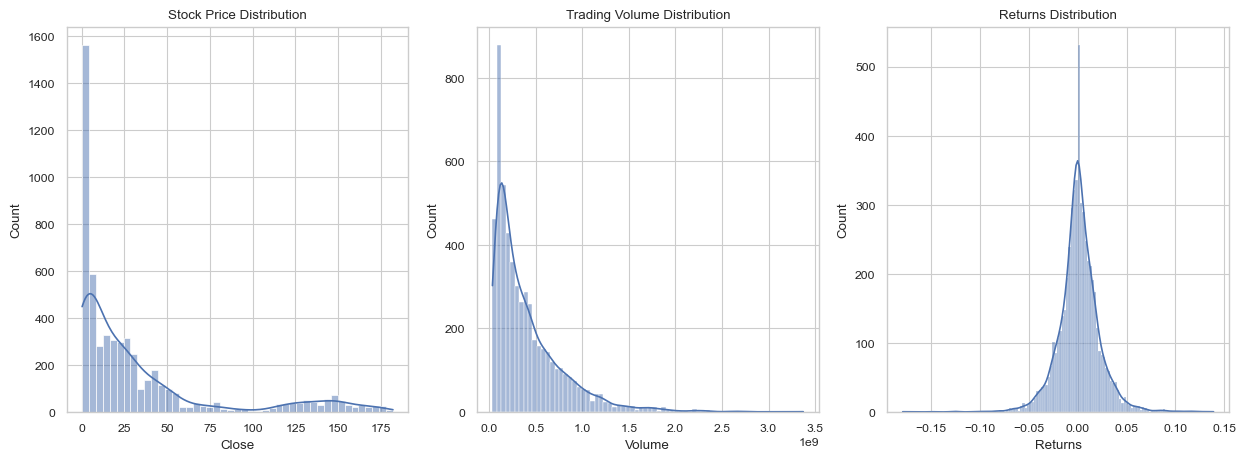

In [289]:
stock_data_analysis.plot_histograms()

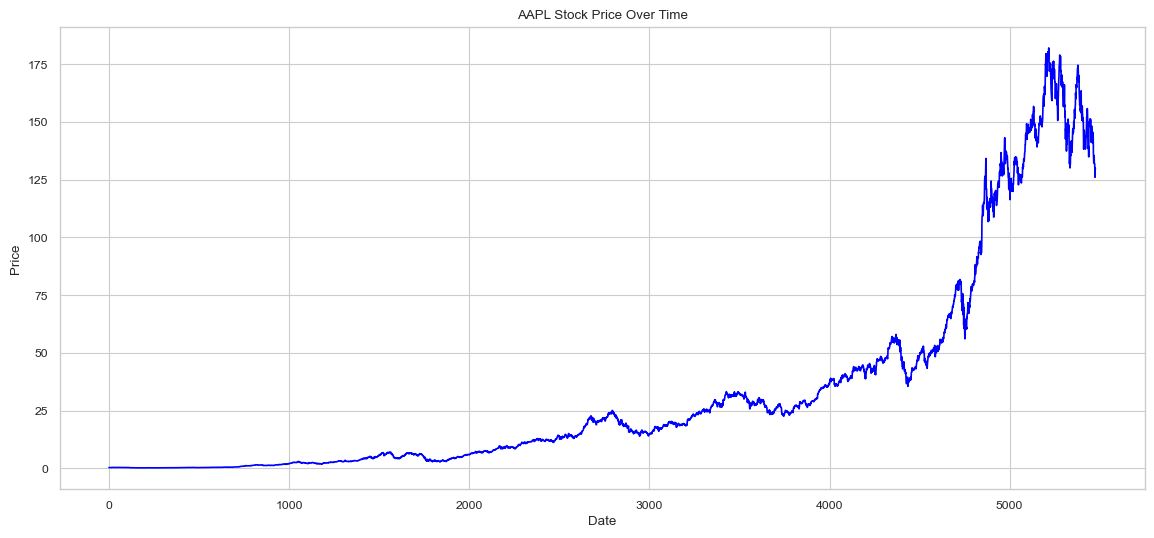

In [290]:
stock_data_analysis.plot_stock_price()


Correlation Matrix:
             Close    Volume   Returns
Close    1.000000 -0.459348 -0.006129
Volume  -0.459348  1.000000  0.017011
Returns -0.006129  0.017011  1.000000


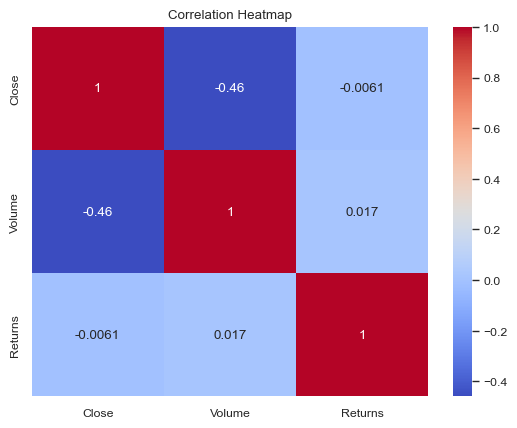

In [291]:
stock_data_analysis.plot_correlation_heatmap()

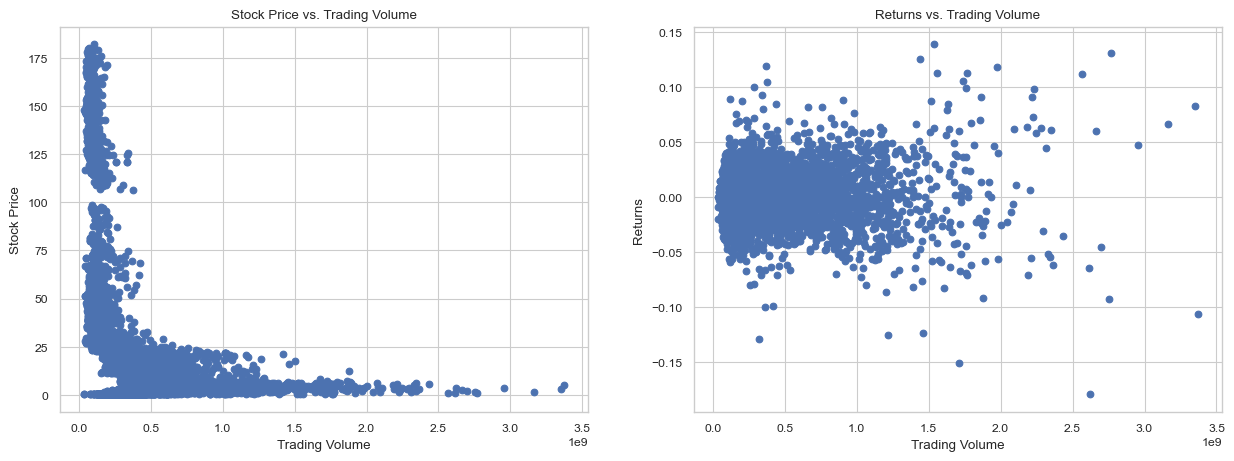

In [292]:
stock_data_analysis.plot_scatter_plots()

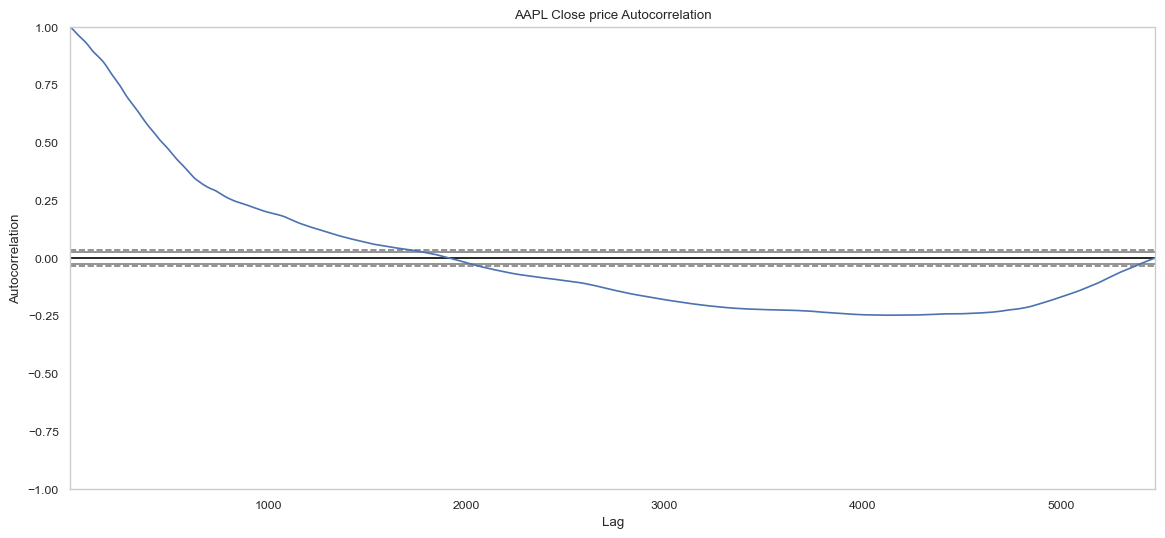

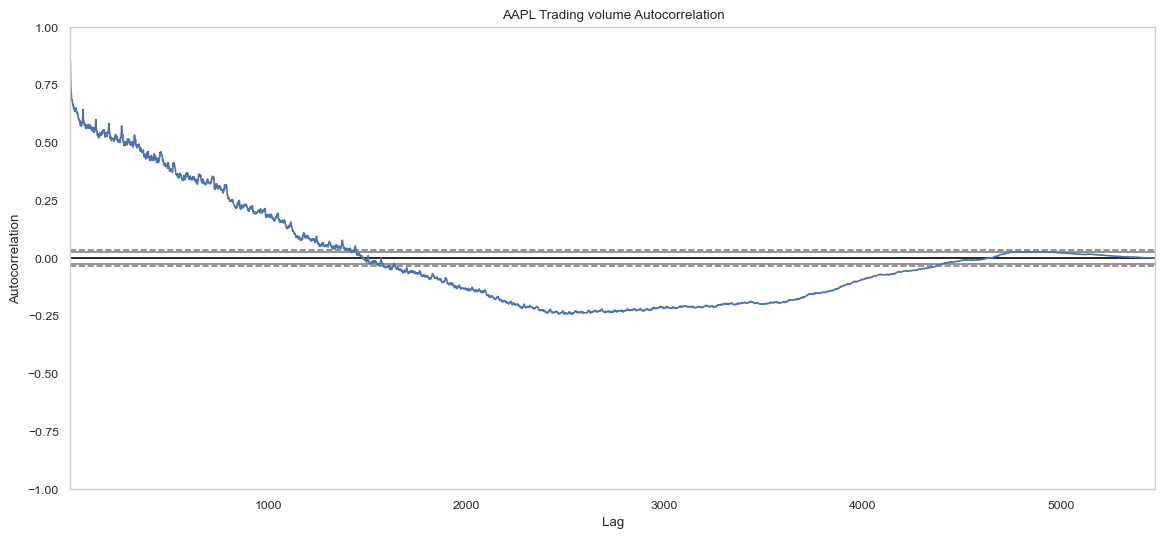

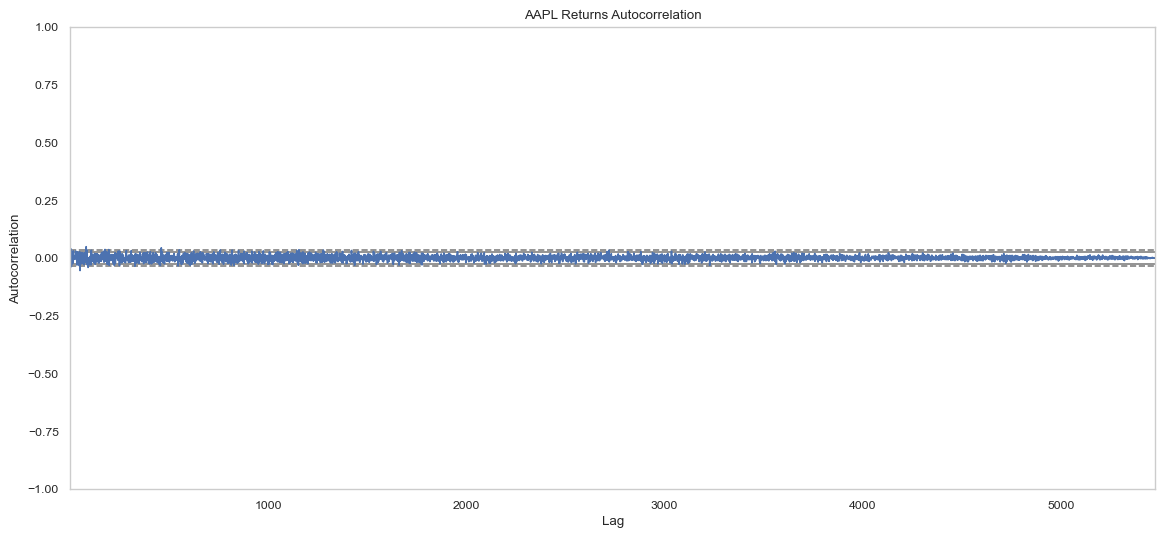

In [293]:
stock_data_analysis.plot_autocorrelation()

Insights from the exploratory data analysis:
1. The scatter plot between stock price and trading volume shows that stock price decreases as trading volume increases.
2. The line plot of the stock price over time shows that the stock price has generally increased over the years. This suggests that the stock has been in an overall upward trend.
3. The histogram of the returns shows that the returns are approximately normally distributed, with the mean close to zero. This is a typical characteristic of stock returns and could be useful for understanding the underlying dynamics of the stock.

### 3. Model training and calibration

In [294]:
class StockPricePredictor:
    def __init__(self, stock_data, configs):
        """
        Initialize the StockPricePredictor with stock data and symbol, window size, and features.
        """
        self.stock_data = stock_data
        self.configs = configs
        self.stock_symbol = configs['data']['stock_symbol']
        self.window_size = configs['data']['sequence_length']
        self.features = configs['data']['columns']
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def preprocess_data(self):
        """
        Preprocess the stock data by scaling and creating input features and target labels.
        """
        stock_close = self.stock_data[self.features]
        stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))

        X, y = [], []
        for i in range(self.window_size, len(self.stock_data)):
            X.append(stock_close[self.features[0]][i - self.window_size:i].values)
            y.append(stock_close[self.features[0]][i])

        X, y = np.array(X), np.array(y)
        return X, y

    def split_data(self, X, y, test_size=0.2):
        """
        Split the data into training and testing datasets.
        """
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        return X_train, X_test, y_train, y_test

    def build_lstm_model(self):
        """
        Build the LSTM model for stock price prediction.
        """
        start_time = time.time()

        model = Sequential()
        for layer in self.configs['model']['layers']:
            neurons = layer['neurons'] if 'neurons' in layer else None
            dropout_rate = layer['rate'] if 'rate' in layer else None
            activation = layer['activation'] if 'activation' in layer else None
            return_seq = layer['return_seq'] if 'return_seq' in layer else None
            input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
            input_dim = layer['input_dim'] if 'input_dim' in layer else None

            if layer['type'] == 'dense':
                model.add(Dense(neurons, activation=activation, kernel_regularizer=l1_l2(l1=self.configs['model']['l1_lambda'], l2=self.configs['model']['l2_lambda'])))
            if layer['type'] == 'lstm':
                model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq, kernel_regularizer=l1_l2(l1=self.configs['model']['l1_lambda'], l2=self.configs['model']['l2_lambda'])))
            if layer['type'] == 'bilstm':
                model.add(Bidirectional(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq, kernel_regularizer=l1_l2(l1=self.configs['model']['l1_lambda'], l2=self.configs['model']['l2_lambda']))))
            if layer['type'] == 'gru':
                model.add(GRU(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq, kernel_regularizer=l1_l2(l1=self.configs['model']['l1_lambda'], l2=self.configs['model']['l2_lambda'])))
            if layer['type'] == 'dropout':
                model.add(Dropout(dropout_rate))

        model.compile(optimizer=self.configs['model']['optimizer'], loss=self.configs['model']['loss'])
        
        end_time = time.time()
        print(f'[Model] Model Compiled using {end_time - start_time} s')
        return model

    def train_and_evaluate(self, X_train, X_test, y_train, y_test, batch_size, plot_loss=False):
        """
        Train the LSTM model and evaluate its performance using Mean Absolute Error (MAE).
        """
        model = self.build_lstm_model()
        # plot_model(model, to_file='model.png', show_shapes=True)

        # Add early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=self.configs['training']['epochs'], validation_split=0.2, callbacks=[early_stopping], verbose=0)

        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        print(f"Mean Absolute Error: {mae}")

        if plot_loss:
            # Plot the training loss curve
            plt.figure(figsize=(14, 6))
            plt.plot(history.history['loss'])
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training Loss vs. Epochs")
            plt.savefig('training_loss.png', dpi=600)
            plt.show()

        return y_pred, mae
    
    def k_fold_cross_validation(self, X, y):
        """
        Perform k-fold cross-validation and return the average Mean Absolute Error (MAE).
        """
        k = self.configs['training']['k']
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        mae_scores = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Reshape the input for compatibility with the LSTM layer
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

            y_pred, mae = self.train_and_evaluate(X_train, X_test, y_train, y_test, self.configs['training']['batch_size'])
            mae_scores.append(mae)

        average_mae = np.mean(mae_scores)

        return average_mae


    def plot_predictions(self, y_test, y_pred):
        """
        Plot true and predicted stock prices.
        """
        y_pred_transformed = self.scaler.inverse_transform(y_pred)
        y_test_transformed = self.scaler.inverse_transform(y_test.reshape(-1, 1))

        test_dates = self.stock_data.index[self.window_size + len(y_train):]
        plt.figure(figsize=(14, 6))
        plt.plot(test_dates, y_test_transformed, label='True Prices', color='blue')
        plt.plot(test_dates, y_pred_transformed, label='Predicted Prices', color='red')
        plt.xlabel("Date index")
        plt.ylabel("Price")
        plt.title(f"{self.stock_symbol} Stock Price Prediction")
        plt.legend()
        plt.savefig('prediction.png', dpi=600)
        plt.show()

    def extreme_error_analysis(self, all_y_test, all_y_pred, percentile=95):
        """
        Analyze extreme errors between true and predicted values.

        Parameters:
        all_y_test (numpy.ndarray): Array of true values.
        all_y_pred (numpy.ndarray): Array of predicted values.
        percentile (float): Percentile to define extreme errors.
        """
        errors = np.abs(all_y_test - all_y_pred)
        threshold = np.percentile(errors, percentile)
        extreme_errors = errors > threshold

        extreme_error_indices = np.where(extreme_errors)[0]
        extreme_error_true_values = all_y_test[extreme_error_indices]
        extreme_error_pred_values = all_y_pred[extreme_error_indices]

        plt.figure(figsize=(14, 6))
        plt.scatter(extreme_error_indices, extreme_error_true_values, label='True Prices', color='blue', s=1)
        plt.scatter(extreme_error_indices, extreme_error_pred_values, label='Predicted Prices', color='red', s=1)
        plt.xlabel("Index")
        plt.ylabel("Price")
        plt.title("Extreme Error Analysis")
        plt.legend()
        plt.savefig('extreme_error.png', dpi=600)
        plt.show()

/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


[Model] Model Compiled using 0.2858717441558838 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.02195229245925871


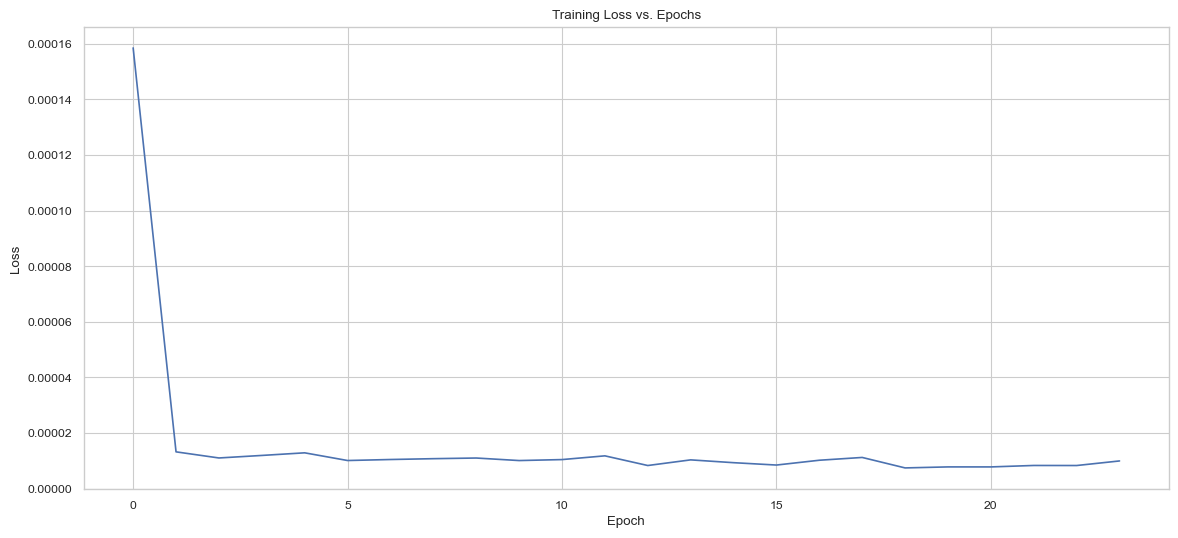

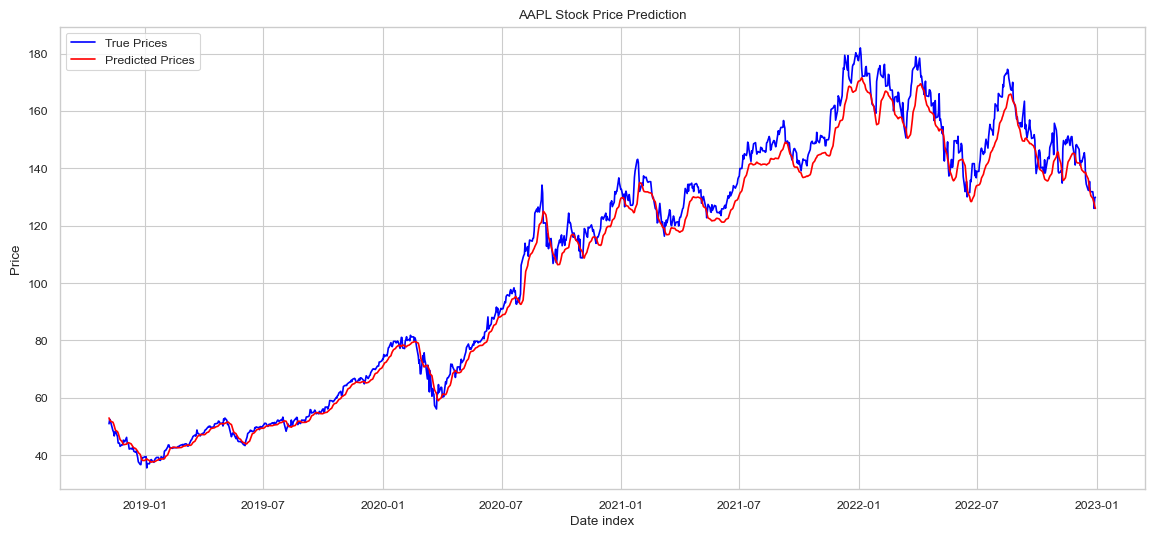

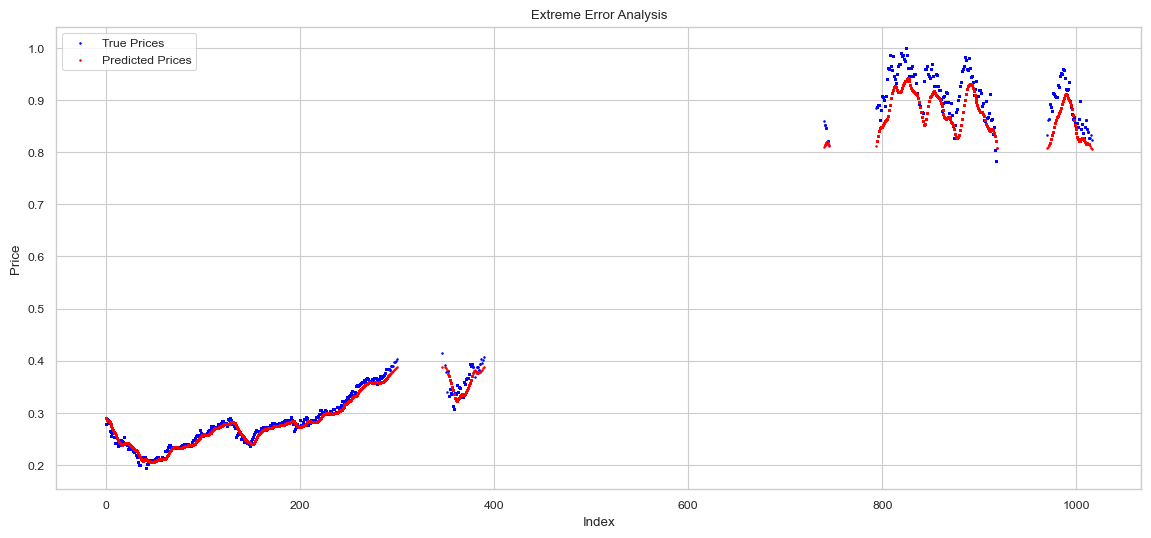

In [295]:
# Read the config file
configs = json.load(open('config.json', 'r'))

if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

# Read the stock data
stock_data = pd.read_csv(f"{configs['data']['stock_symbol']}_preprocessed_data.csv", index_col="Date", parse_dates=True)

# Instantiate the StockPricePredictor
predictor = StockPricePredictor(stock_data, configs)

# Preprocess the data
X, y = predictor.preprocess_data()

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = predictor.split_data(X, y, 1 - configs['data']['train_test_split']) 

# Train the model and make predictions
y_pred, _ = predictor.train_and_evaluate(X_train, X_test, y_train, y_test, configs['training']['batch_size'], plot_loss=True)

# Plot true and predicted stock prices
predictor.plot_predictions(y_test, y_pred)

# Perform extreme error analysis
predictor.extreme_error_analysis(y_test, y_pred)

In [296]:
# k-fold cross validation
average_mae = predictor.k_fold_cross_validation(X, y)
print(f"Average Mean Absolute Error: {average_mae} of {configs['training']['k']}-fold cross-validation")

[Model] Model Compiled using 0.15247416496276855 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.005113812004940588
[Model] Model Compiled using 0.14522385597229004 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.003986274504130433
[Model] Model Compiled using 0.13936519622802734 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.004091189228064349
[Model] Model Compiled using 0.13991498947143555 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.004168862620986851
[Model] Model Compiled using 0.1366710662841797 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.004971476724328876
Average Mean Absolute Error: 0.00446632301649022 of 5-fold cross-validation


#### Calibration

Training with batch size: 8
Experiment 1
[Model] Model Compiled using 0.13886427879333496 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.004305380865508904
[Model] Model Compiled using 0.13730788230895996 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.00412179880037309
[Model] Model Compiled using 0.13214898109436035 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.004884259355474647
[Model] Model Compiled using 0.13349699974060059 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.0056195534888523555
[Model] Model Compiled using 0.13863778114318848 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.004355506814762406
Experiment 2
[Model] Model Compiled using 0.133620023727417 s
34/34 [==============================] - 1s 8ms/step
Mean Absolute Error: 0.006367811452869372
[Model] Model Compiled using 0.1330113410949707 s
34/34 [===============

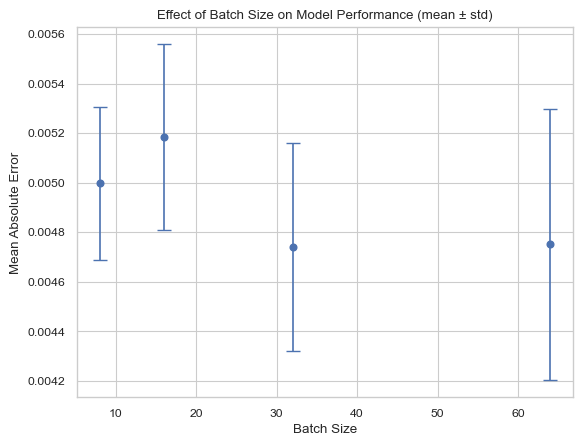

In [297]:
# train and evaluate the model using different batch sizes
batch_sizes = [8, 16, 32, 64]
n_experiments = 3
mae_scores = np.zeros((len(batch_sizes), n_experiments))

for i, batch_size in enumerate(batch_sizes):
    print(f"Training with batch size: {batch_size}")
    for j in range(n_experiments):
        print(f"Experiment {j + 1}")
        mae = predictor.k_fold_cross_validation(X, y)
        mae_scores[i, j] = mae

# Calculate mean and standard deviation for each batch size
mae_mean = np.mean(mae_scores, axis=1)
mae_std = np.std(mae_scores, axis=1)

# Plot MAE scores for different batch sizes with error bars
plt.errorbar(batch_sizes, mae_mean, yerr=mae_std, fmt='o', capsize=5)
plt.xlabel('Batch Size')
plt.ylabel('Mean Absolute Error')
plt.title('Effect of Batch Size on Model Performance (mean ± std)')
plt.savefig('batchsize.png', dpi=600)
plt.show()

Training with 1 LSTM layers
Experiment 1
[Model] Model Compiled using 0.0849912166595459 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004009337376185787
[Model] Model Compiled using 0.07804179191589355 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004168024326959051
[Model] Model Compiled using 0.07602381706237793 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0033833878118012754
[Model] Model Compiled using 0.07322216033935547 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004367969922206582
[Model] Model Compiled using 0.07580995559692383 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004194844287250451
Experiment 2
[Model] Model Compiled using 0.07332921028137207 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0032205579105539566
[Model] Model Compiled using 0.07103681564331055 s
34/34 [===========

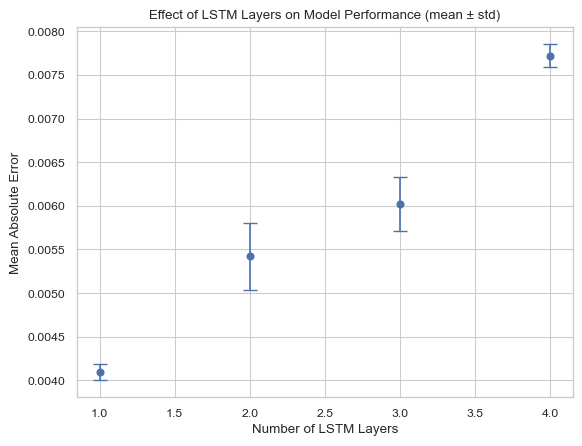

In [298]:
# train and evaluate the model using different number of LSTM layers
lstm_layer_counts = [1, 2, 3, 4]
n_experiments = 3
mae_scores = np.zeros((len(lstm_layer_counts), n_experiments))

for i in lstm_layer_counts:
    print(f"Training with {i} LSTM layers")
    
    # Read the config file
    configs = json.load(open(f'config_lstm_{i}.json', 'r'))
    
    for j in range(n_experiments):
        print(f"Experiment {j + 1}")

        # Instantiate the StockPricePredictor
        predictor = StockPricePredictor(stock_data, configs)

        # Split the data into training and testing datasets
        X_train, X_test, y_train, y_test = predictor.split_data(X, y, 1 - configs['data']['train_test_split']) 

        # Train the model and make predictions
        mae = predictor.k_fold_cross_validation(X, y)
        
        mae_scores[i-1, j] = mae

# Calculate mean and standard deviation for each LSTM layer count
mae_mean = np.mean(mae_scores, axis=1)
mae_std = np.std(mae_scores, axis=1)

# Plot MAE scores for different LSTM layer counts with error bars
plt.errorbar(lstm_layer_counts, mae_mean, yerr=mae_std, fmt='o', capsize=5)
plt.xlabel('Number of LSTM Layers')
plt.ylabel('Mean Absolute Error')
plt.title('Effect of LSTM Layers on Model Performance (mean ± std)')
plt.savefig('layernum.png', dpi=600)
plt.show()

Training with L1: 0.0, L2: 0.0
[Model] Model Compiled using 0.08685612678527832 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0034201559242937893
[Model] Model Compiled using 0.07320284843444824 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004035110772281121
[Model] Model Compiled using 0.07229804992675781 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0038803965983280684
[Model] Model Compiled using 0.07711172103881836 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005429966503748039
[Model] Model Compiled using 0.07383084297180176 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004043150699603866
[Model] Model Compiled using 0.07443690299987793 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003429322759588638
[Model] Model Compiled using 0.07763481140136719 s
34/34 [==============================] -

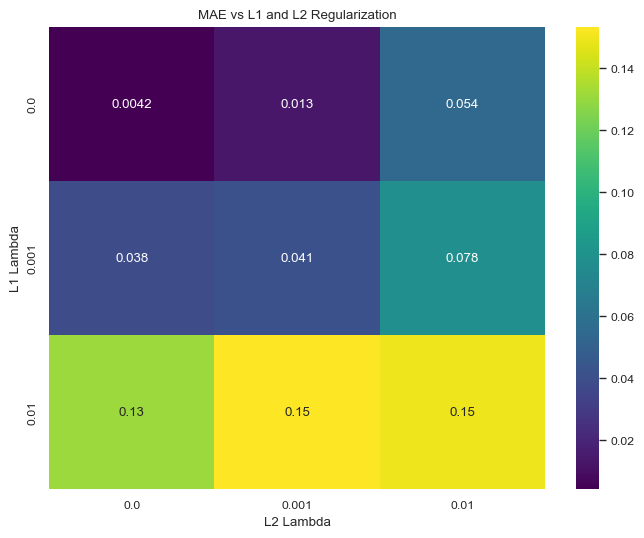

In [299]:
# assess the effect of regularization techniques
l1_lambdas = [0.0, 0.001, 0.01]
l2_lambdas = [0.0, 0.001, 0.01]
results = []
num_experiments = 3
# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))

for l1_lambda in l1_lambdas:
    for l2_lambda in l2_lambdas:
        print(f"Training with L1: {l1_lambda}, L2: {l2_lambda}")
        
        configs['model']['l1_lambda'] = l1_lambda
        configs['model']['l2_lambda'] = l2_lambda
        predictor = StockPricePredictor(stock_data, configs)

        mae_scores = []
        for i in range(num_experiments):
            # Train the model and make predictions
            mae = predictor.k_fold_cross_validation(X, y)
            mae_scores.append(mae)

        average_mae = np.mean(mae_scores)
        # Store the results
        results.append({
            'l1_lambda': l1_lambda,
            'l2_lambda': l2_lambda,
            'mae': average_mae
        })

# Find the best configuration
best_config = min(results, key=lambda x: x['mae'])
print(f"Best configuration: L1: {best_config['l1_lambda']}, L2: {best_config['l2_lambda']}, Avg MAE: {best_config['mae']}")

# Create a heatmap of the MAE vs L1 and L2 regularization
mae_matrix = np.array([result['mae'] for result in results]).reshape(len(l1_lambdas), len(l2_lambdas))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(mae_matrix, annot=True, cmap='viridis', xticklabels=l2_lambdas, yticklabels=l1_lambdas, ax=ax)
ax.set_xlabel('L2 Lambda')
ax.set_ylabel('L1 Lambda')
ax.set_title('MAE vs L1 and L2 Regularization')
plt.savefig('l1l2.png', dpi=600)
plt.show()

### 4. Model evaluation and ablation study

Training with dropout rates: 0
[Model] Model Compiled using 0.07762908935546875 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0034204893198345734
[Model] Model Compiled using 0.07481861114501953 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005510016889639246
[Model] Model Compiled using 0.07267379760742188 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0028038601614230156
[Model] Model Compiled using 0.08039283752441406 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0051905002844039
[Model] Model Compiled using 0.0742180347442627 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005515062907245535
[Model] Model Compiled using 2.2023496627807617 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.00371209380569794
[Model] Model Compiled using 0.07340431213378906 s
34/34 [==============================] - 0s 2

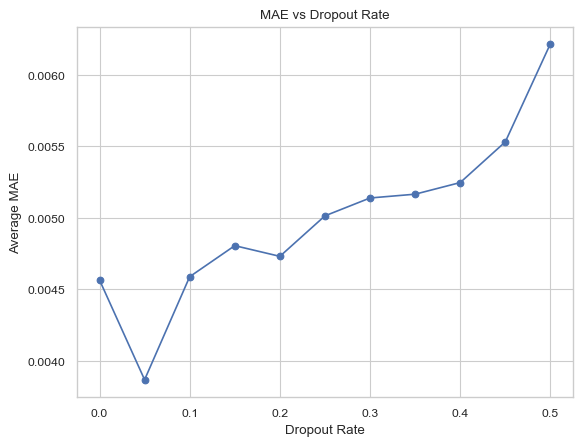

In [300]:
# assess the effect of dropout rate
dropout_rates = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
results = []
num_experiments = 3
# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))

for dropout_rate in dropout_rates:
    print(f"Training with dropout rates: {dropout_rate}")
    
    for layer in configs['model']['layers']:
        if 'rate' in layer:
            layer['rate'] = dropout_rate
    predictor = StockPricePredictor(stock_data, configs)

    mae_scores = []
    for i in range(num_experiments):
        # Train the model and make predictions
        mae = predictor.k_fold_cross_validation(X, y)
        mae_scores.append(mae)

    average_mae = np.mean(mae_scores)
    # Store the results
    results.append({
        'dropout_rates': dropout_rate,
        'mae': average_mae
    })

# Find the best configuration
best_config = min(results, key=lambda x: x['mae'])
print(f"Best configuration: Dropout Rate: {best_config['dropout_rates']}, Avg MAE: {best_config['mae']}")
# Plot the MAE vs dropout rate
dropout_rates = [result['dropout_rates'] for result in results]
mae_values = [result['mae'] for result in results]

plt.plot(dropout_rates, mae_values)
plt.scatter(dropout_rates, mae_values)
plt.xlabel('Dropout Rate')
plt.ylabel('Average MAE')
plt.title('MAE vs Dropout Rate')
plt.savefig('dropout.png', dpi=600)
plt.show()

Training with LSTM:
[Model] Model Compiled using 0.07984709739685059 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004313354595144438
[Model] Model Compiled using 0.07374787330627441 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004477495891761749
[Model] Model Compiled using 0.07313203811645508 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003895609356644457
[Model] Model Compiled using 0.07241487503051758 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.00501815702610204
[Model] Model Compiled using 0.07827496528625488 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005101362608373866
[Model] Model Compiled using 0.07512879371643066 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003942091743782138
[Model] Model Compiled using 0.07573390007019043 s
34/34 [==============================] - 0s 2ms/step
M

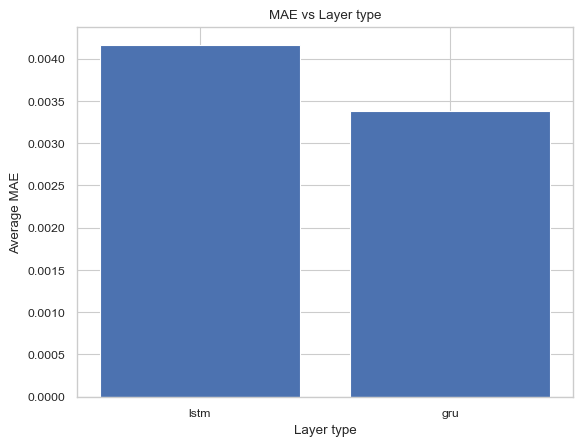

In [301]:
# Replace LSTM layers with GRU layers
results = []
num_experiments = 10
# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))

print(f"Training with LSTM:")

predictor = StockPricePredictor(stock_data, configs)

mae_scores = []
for i in range(num_experiments):
    # Train the model and make predictions
    mae = predictor.k_fold_cross_validation(X, y)
    mae_scores.append(mae)

average_mae = np.mean(mae_scores)
# Store the results
results.append({
    'type': 'lstm',
    'mae': average_mae
})

# Read the config file
configs = json.load(open(f'config_gru_1.json', 'r'))

print(f"Training with GRU:")

predictor = StockPricePredictor(stock_data, configs)

mae_scores = []
for i in range(num_experiments):
    # Train the model and make predictions
    mae = predictor.k_fold_cross_validation(X, y)
    mae_scores.append(mae)

average_mae = np.mean(mae_scores)
# Store the results
results.append({
    'type': 'gru',
    'mae': average_mae
})

# Find the best configuration
best_config = min(results, key=lambda x: x['mae'])
print(f"Best configuration: Layer type: {best_config['type']}, Avg MAE: {best_config['mae']}")
# Plot the MAE vs layer type
layer_types = [result['type'] for result in results]
mae_values = [result['mae'] for result in results]

plt.bar(layer_types, mae_values)
plt.xlabel('Layer type')
plt.ylabel('Average MAE')
plt.title('MAE vs Layer type')
plt.savefig('layertype.png', dpi=600)
plt.show()

Training with pre_factor of number if neurons: 0.5
[Model] Model Compiled using 0.08042097091674805 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004451925654516087
[Model] Model Compiled using 0.06977272033691406 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0053578683317799065
[Model] Model Compiled using 0.07082295417785645 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005771851145265685
[Model] Model Compiled using 0.07056999206542969 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0061938131153161345
[Model] Model Compiled using 0.06987214088439941 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004255419890137612
[Model] Model Compiled using 0.0672910213470459 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004711692631502291
[Model] Model Compiled using 0.0677180290222168 s
34/34 [===============

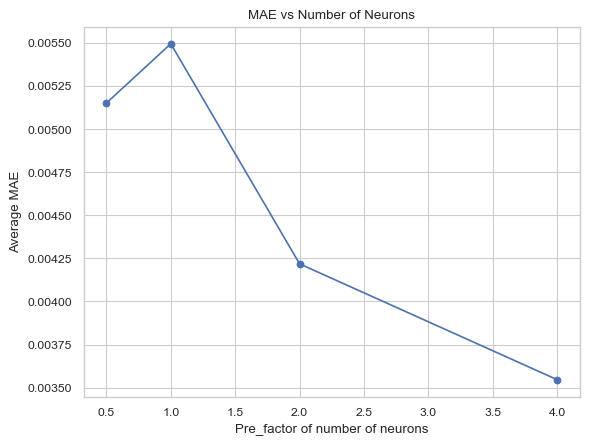

In [302]:
# assess the effect of number of neurons
pre_factors = [0.5,1,2,4]
results = []
num_experiments = 3
# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))

for i, prefactor in enumerate(pre_factors):
    print(f"Training with pre_factor of number if neurons: {prefactor}")
    
    for layer in configs['model']['layers'][:-1]:
        if 'neurons' in layer:
            layer['neurons'] = int(layer['neurons'] * prefactor)
    predictor = StockPricePredictor(stock_data, configs)

    mae_scores = []
    for j in range(num_experiments):
        # Train the model and make predictions
        mae = predictor.k_fold_cross_validation(X, y)
        mae_scores.append(mae)

    average_mae = np.mean(mae_scores)
    # Store the results
    results.append({
        'pre_factors': prefactor,
        'mae': average_mae
    })

# Find the best configuration
best_config = min(results, key=lambda x: x['mae'])
print(f"Best configuration: Pre_factor: {best_config['pre_factors']}, Avg MAE: {best_config['mae']}")
# Plot the MAE vs pre_factors of number of neurons
pre_factors = [result['pre_factors'] for result in results]
mae_values = [result['mae'] for result in results]

plt.plot(pre_factors, mae_values)
plt.scatter(pre_factors, mae_values)
plt.xlabel('Pre_factor of number of neurons')
plt.ylabel('Average MAE')
plt.title('MAE vs Number of Neurons')
plt.savefig('neurons.png', dpi=600)
plt.show()

Training with LSTM:
[Model] Model Compiled using 0.07618093490600586 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0030751253124003124
[Model] Model Compiled using 0.07228899002075195 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003990809568514874
[Model] Model Compiled using 0.07034516334533691 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0035066200622388983
[Model] Model Compiled using 0.06986403465270996 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005095556795145748
[Model] Model Compiled using 0.07764196395874023 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005357404115566747
[Model] Model Compiled using 0.06868600845336914 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003079959941535675
[Model] Model Compiled using 0.07003498077392578 s
34/34 [==============================] - 0s 2ms/ste

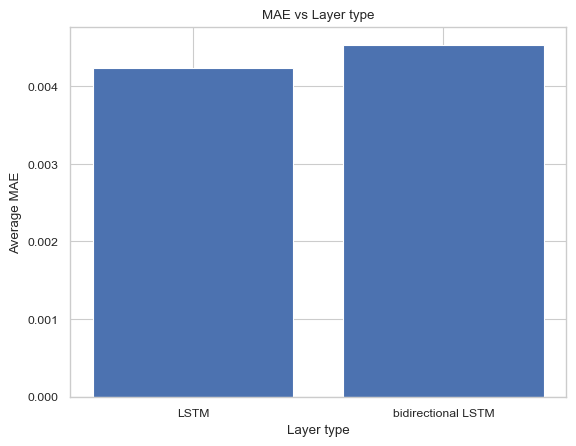

In [303]:
# use bidirectional LSTM layers instead of standard LSTM layers
results = []
num_experiments = 5
# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))

print(f"Training with LSTM:")

predictor = StockPricePredictor(stock_data, configs)

mae_scores = []
for i in range(num_experiments):
    # Train the model and make predictions
    mae = predictor.k_fold_cross_validation(X, y)
    mae_scores.append(mae)

average_mae = np.mean(mae_scores)
# Store the results
results.append({
    'type': 'LSTM',
    'mae': average_mae
})

# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))
for layer in configs['model']['layers']:
    if layer['type'] == 'lstm':
        layer['type'] = 'bilstm'

print(f"Training with bidirectional LSTM:")

predictor = StockPricePredictor(stock_data, configs)

mae_scores = []
for i in range(num_experiments):
    # Train the model and make predictions
    mae = predictor.k_fold_cross_validation(X, y)
    mae_scores.append(mae)

average_mae = np.mean(mae_scores)
# Store the results
results.append({
    'type': 'bidirectional LSTM',
    'mae': average_mae
})

# Find the best configuration
best_config = min(results, key=lambda x: x['mae'])
print(f"Best configuration: Layer type: {best_config['type']}, Avg MAE: {best_config['mae']}")
# Plot the MAE vs layer type
layer_types = [result['type'] for result in results]
mae_values = [result['mae'] for result in results]

plt.bar(layer_types, mae_values)
plt.xlabel('Layer type')
plt.ylabel('Average MAE')
plt.title('MAE vs Layer type')
plt.savefig('layertypebi.png', dpi=600)
plt.show()

Training with optimizer: adam
[Model] Model Compiled using 0.08010196685791016 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003551173284529326
[Model] Model Compiled using 0.07526826858520508 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004006591759648845
[Model] Model Compiled using 0.07220292091369629 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004549788746471571
[Model] Model Compiled using 0.06907486915588379 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005494268441006799
[Model] Model Compiled using 0.07295012474060059 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003645522728996755
[Model] Model Compiled using 0.06893301010131836 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004165105708948881
[Model] Model Compiled using 0.06826090812683105 s
34/34 [==============================] - 0s

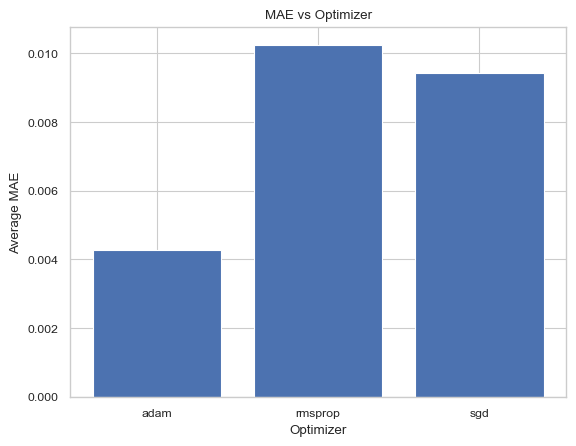

In [304]:
# assess the effect of different optimizers
optimizers = ['adam', 'rmsprop', 'sgd']
results = []
num_experiments = 5
# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))

for i, optimizer in enumerate(optimizers):
    print(f"Training with optimizer: {optimizer}")

    configs['model']['optimizer'] = optimizer
    
    predictor = StockPricePredictor(stock_data, configs)

    mae_scores = []
    for j in range(num_experiments):
        # Train the model and make predictions
        mae = predictor.k_fold_cross_validation(X, y)
        mae_scores.append(mae)

    average_mae = np.mean(mae_scores)
    # Store the results
    results.append({
        'optimizer': optimizer,
        'mae': average_mae
    })

# Find the best configuration
best_config = min(results, key=lambda x: x['mae'])
print(f"Best configuration: Optimizer: {best_config['optimizer']}, Avg MAE: {best_config['mae']}")

# Plot the MAE vs optimizer
optimizer_names = [result['optimizer'] for result in results]
mae_values = [result['mae'] for result in results]

plt.bar(optimizer_names, mae_values)
plt.xlabel('Optimizer')
plt.ylabel('Average MAE')
plt.title('MAE vs Optimizer')
plt.savefig('optimizer.png', dpi=600)
plt.show()

Training with linear activation:
[Model] Model Compiled using 0.07599782943725586 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003604014705362286
[Model] Model Compiled using 0.07173395156860352 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004352253686683612
[Model] Model Compiled using 0.07062506675720215 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0037240223051585907
[Model] Model Compiled using 0.07100391387939453 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003306603579363133
[Model] Model Compiled using 0.06907105445861816 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004088213944346969
[Model] Model Compiled using 0.06999492645263672 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003538016328236622
[Model] Model Compiled using 0.0742349624633789 s
34/34 [==============================] -

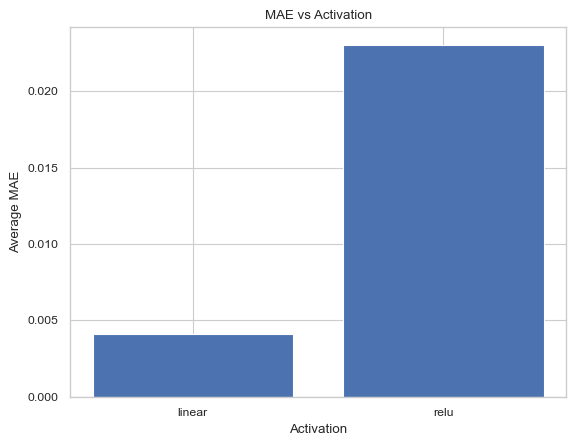

In [305]:
# model with different activation functions
results = []
num_experiments = 10
# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))

print(f"Training with linear activation:")

predictor = StockPricePredictor(stock_data, configs)

mae_scores = []
for i in range(num_experiments):
    # Train the model and make predictions
    mae = predictor.k_fold_cross_validation(X, y)
    mae_scores.append(mae)

average_mae = np.mean(mae_scores)
# Store the results
results.append({
    'activation': 'linear',
    'mae': average_mae
})

# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))
for layer in configs['model']['layers']:
    if 'activation' in layer:
        layer['activation'] = 'relu'

print(f"Training with RelU activation:")

predictor = StockPricePredictor(stock_data, configs)

mae_scores = []
for i in range(num_experiments):
    # Train the model and make predictions
    mae = predictor.k_fold_cross_validation(X, y)
    mae_scores.append(mae)

average_mae = np.mean(mae_scores)
# Store the results
results.append({
    'activation': 'relu',
    'mae': average_mae
})

# Find the best configuration
best_config = min(results, key=lambda x: x['mae'])
print(f"Best configuration: activation: {best_config['activation']}, Avg MAE: {best_config['mae']}")
# Plot the MAE vs activation
activations = [result['activation'] for result in results]
mae_values = [result['mae'] for result in results]

plt.bar(activations, mae_values)
plt.xlabel('Activation')
plt.ylabel('Average MAE')
plt.title('MAE vs Activation')
plt.savefig('activation.png', dpi=600)
plt.show()

Training with window size: 30
[Model] Model Compiled using 0.07806611061096191 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004446881988383904
[Model] Model Compiled using 0.07177400588989258 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.005437809665575336
[Model] Model Compiled using 0.08122801780700684 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004558733437509493
[Model] Model Compiled using 0.07128000259399414 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.0028349855636467546
[Model] Model Compiled using 0.06912112236022949 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004068090269158056
[Model] Model Compiled using 0.06918668746948242 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.003610180235847734
[Model] Model Compiled using 0.06888103485107422 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.003932399503817739
[Model] Model Compiled using 0.07103610038757324 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004753764085464488
[Model] Model Compiled using 0.07000398635864258 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.003953616362414757
[Model] Model Compiled using 0.06943607330322266 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004224202561733866
[Model] Model Compiled using 0.07333612442016602 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004769371606852651
[Model] Model Compiled using 0.06985926628112793 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.00454111257687389
[Model] Model Compiled using 0.06858491897583008 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.005108005387635316
[Model] Model Compiled using 0.06855225563049316 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.005577880139104327
[Model] Model Compiled using 0.06851601600646973 s
35/35 [==============================] - 1s 1ms/step
Mean Absolute Error: 0.004384519431105299
[Model] Model Compiled using 0.0709068775177002 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004169340807858866
[Model] Model Compiled using 0.0704641342163086 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004915898192301869
[Model] Model Compiled using 0.07054376602172852 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004622126694565274
[Model] Model Compiled using 0.06848788261413574 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.0034685311782962445
[Model] Model Compiled using 0.06853485107421875 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.0034537908257266142
[Model] Model Compiled using 0.07196593284606934 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.0049263144730573175
[Model] Model Compiled using 0.06930994987487793 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004055496532710664
[Model] Model Compiled using 0.06962990760803223 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.003461328649172509
[Model] Model Compiled using 0.940356969833374 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.006957712813573351
[Model] Model Compiled using 0.06902885437011719 s
35/35 [==============================] - 0s 1ms/step
Mean Absolute Error: 0.004864623413774695
Training with window size: 60
[Model] Model Compiled using 0.06995725631713867 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003330431960232975
[Model] Model Compiled using 0.06791090965270996 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0039508585194867425
[Model] Model Compiled using 0.06797623634338379 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003878684515765386
[Model] Model Compiled using 0.0706791877746582 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.006839511784807763
[Model] Model Compiled using 0.07041692733764648 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005081562110964213
[Model] Model Compiled using 0.07072782516479492 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0034927669164908194
[Model] Model Compiled using 0.06983184814453125 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005079554884249441
[Model] Model Compiled using 0.07707500457763672 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004193023196888121
[Model] Model Compiled using 0.07046818733215332 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004919456775101262
[Model] Model Compiled using 0.07045793533325195 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0037235999563723235
[Model] Model Compiled using 0.06984782218933105 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0029830869188174933
[Model] Model Compiled using 0.07007479667663574 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.00434158636396819
[Model] Model Compiled using 0.06840395927429199 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003941948318327719
[Model] Model Compiled using 0.06842899322509766 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003327719746450809
[Model] Model Compiled using 0.07079100608825684 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0051277876506310065
[Model] Model Compiled using 0.07239007949829102 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0029855993445198825
[Model] Model Compiled using 0.07001090049743652 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0049700594599536435
[Model] Model Compiled using 0.06818509101867676 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0035048618366959046
[Model] Model Compiled using 0.0697929859161377 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004178525177094147
[Model] Model Compiled using 0.07052898406982422 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004102188796256663
[Model] Model Compiled using 0.07213687896728516 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0037088774026274468
[Model] Model Compiled using 0.0685420036315918 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0038996663411602897
[Model] Model Compiled using 0.06686711311340332 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004421740452488349
[Model] Model Compiled using 0.07109355926513672 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0037543551822527706
[Model] Model Compiled using 0.07032918930053711 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004067628168883237
Training with window size: 90
[Model] Model Compiled using 0.07097911834716797 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.004746431795882846
[Model] Model Compiled using 0.07087516784667969 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.005212163588797875
[Model] Model Compiled using 0.0673677921295166 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.0037428818037314633
[Model] Model Compiled using 0.0700688362121582 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.004446373343725141
[Model] Model Compiled using 0.06927704811096191 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.0044565923566113035
[Model] Model Compiled using 0.07494592666625977 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.0033597476782117747
[Model] Model Compiled using 0.07088685035705566 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.003533866562276607
[Model] Model Compiled using 0.07264518737792969 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.006312178307630309
[Model] Model Compiled using 0.06925392150878906 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.004015217691851062
[Model] Model Compiled using 0.07057905197143555 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.006390955424470266
[Model] Model Compiled using 0.07266879081726074 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.004565603088201311
[Model] Model Compiled using 0.07003164291381836 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.003685165996702998
[Model] Model Compiled using 0.0709848403930664 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.0035963744927960334
[Model] Model Compiled using 0.0686490535736084 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.005393387631049947
[Model] Model Compiled using 0.07191014289855957 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.004652634677764996
[Model] Model Compiled using 0.0721890926361084 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.004365818098171897
[Model] Model Compiled using 0.06773829460144043 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.0037169384091722177
[Model] Model Compiled using 0.06937003135681152 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.0033325699943877705
[Model] Model Compiled using 0.07332420349121094 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.005755626007963849
[Model] Model Compiled using 0.06829309463500977 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.004950247699859234
[Model] Model Compiled using 0.07038497924804688 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.003093288147194296
[Model] Model Compiled using 0.06844902038574219 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.0056296244323735325
[Model] Model Compiled using 0.9887740612030029 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.004009328922631649
[Model] Model Compiled using 0.06907176971435547 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.005316008854394209
[Model] Model Compiled using 0.06754398345947266 s
34/34 [==============================] - 0s 3ms/step
Mean Absolute Error: 0.004942355112818626
Best configuration: window_size: 60, Avg MAE: 0.004152203271219465


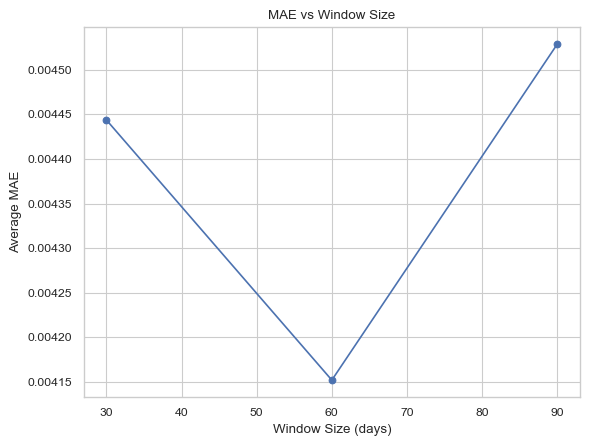

In [306]:
# assess window size
window_sizes = [30,60,90]
results = []
num_experiments = 5
# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))

for i, window_size in enumerate(window_sizes):
    print(f"Training with window size: {window_size}")
    
    configs['data']['sequence_length'] = window_size
    for layer in configs['model']['layers']:
        if 'input_timesteps' in layer:
            layer['input_timesteps'] = window_size
    predictor = StockPricePredictor(stock_data, configs)

    mae_scores = []
    for j in range(num_experiments):
        # Preprocess the data
        X, y = predictor.preprocess_data()

        # Split the data into training and testing datasets
        X_train, X_test, y_train, y_test = predictor.split_data(X, y, 1 - configs['data']['train_test_split'])
         
        # Train the model and make predictions
        mae = predictor.k_fold_cross_validation(X, y)
        mae_scores.append(mae)

    average_mae = np.mean(mae_scores)
    # Store the results
    results.append({
        'window_size': window_size,
        'mae': average_mae
    })

# Find the best configuration
best_config = min(results, key=lambda x: x['mae'])
print(f"Best configuration: window_size: {best_config['window_size']}, Avg MAE: {best_config['mae']}")
# Plot the MAE vs window_size
window_sizes = [result['window_size'] for result in results]
mae_values = [result['mae'] for result in results]

plt.plot(window_sizes, mae_values)
plt.scatter(window_sizes, mae_values)
plt.xlabel('Window Size (days)')
plt.ylabel('Average MAE')
plt.title('MAE vs Window Size')
plt.savefig('windowsize.png', dpi=600)
plt.show()

Training with 5 years data
[*********************100%***********************]  1 of 1 completed
[Model] Model Compiled using 0.0741729736328125 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.01058246009971
[Model] Model Compiled using 0.07291603088378906 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.007141916029146804
[Model] Model Compiled using 0.07239103317260742 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.006569206365586774
[Model] Model Compiled using 0.07152891159057617 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.01136548779258245
[Model] Model Compiled using 0.07546210289001465 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.011502442662929992
[Model] Model Compiled using 0.0716090202331543 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.008887225151054478
[Model] Model Compiled using 0.0729210376739502 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.006781258178523147
[Model] Model Compiled using 0.0709388256072998 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.014000729110606016
[Model] Model Compiled using 0.07275700569152832 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.009577006833147722
[Model] Model Compiled using 0.06987810134887695 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.012583555135994925
[Model] Model Compiled using 0.07227301597595215 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.01068515136069956
[Model] Model Compiled using 0.06934905052185059 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.008684369828558677
[Model] Model Compiled using 0.07277488708496094 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.011169336227140884
[Model] Model Compiled using 0.07191205024719238 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.011383119222190244
[Model] Model Compiled using 0.07430601119995117 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.009351946015187152
[Model] Model Compiled using 0.07076382637023926 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.009842618464271946
[Model] Model Compiled using 0.07271814346313477 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.009105946347883979
[Model] Model Compiled using 0.08087420463562012 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.014771653893906953
[Model] Model Compiled using 0.07396411895751953 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.01002297130164565
[Model] Model Compiled using 0.07451534271240234 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.009174620850236981
[Model] Model Compiled using 0.07188200950622559 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.008557051708323516
[Model] Model Compiled using 0.07249283790588379 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.009537344742055325
[Model] Model Compiled using 0.9947471618652344 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.019092469613946894
[Model] Model Compiled using 0.07594013214111328 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.007699716935981248
[Model] Model Compiled using 0.07286882400512695 s
10/10 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.010009034765872345
Training with 10 years data
[*********************100%***********************]  1 of 1 completed
[Model] Model Compiled using 0.06963801383972168 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005476659467899892
[Model] Model Compiled using 0.0728142261505127 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0032529464182394796
[Model] Model Compiled using 0.07149386405944824 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005093253232986314
[Model] Model Compiled using 0.07139897346496582 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0029171464239870406
[Model] Model Compiled using 0.07166814804077148 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005902072813777377
[Model] Model Compiled using 0.07200288772583008 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0060243958597185855
[Model] Model Compiled using 0.07833480834960938 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0039624073627185594
[Model] Model Compiled using 0.071990966796875 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0034610660596197567
[Model] Model Compiled using 0.0733327865600586 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0050069930004695215
[Model] Model Compiled using 0.07143187522888184 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003989553050544926
[Model] Model Compiled using 0.07065391540527344 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005087962750544388
[Model] Model Compiled using 0.07111883163452148 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0035837889526776157
[Model] Model Compiled using 0.07115697860717773 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.006315051416711545
[Model] Model Compiled using 0.07169198989868164 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005034791110531854
[Model] Model Compiled using 0.07317090034484863 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.005046299158476686
[Model] Model Compiled using 0.07202720642089844 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.00943895552130955
[Model] Model Compiled using 0.07155084609985352 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004475997835994472
[Model] Model Compiled using 0.07169580459594727 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.006906591778077875
[Model] Model Compiled using 0.06996989250183105 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.006835574503311787
[Model] Model Compiled using 0.07026910781860352 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004611998045666125
[Model] Model Compiled using 0.06912469863891602 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.008220679945501934
[Model] Model Compiled using 0.06936979293823242 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004062380760641153
[Model] Model Compiled using 0.07287716865539551 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0062210717355710154
[Model] Model Compiled using 0.07027792930603027 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0036065782810141313
[Model] Model Compiled using 0.07394719123840332 s
18/18 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.007730644217031028
Training with 15 years data
[*********************100%***********************]  1 of 1 completed
[Model] Model Compiled using 0.07194113731384277 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004997234960753238
[Model] Model Compiled using 0.07061386108398438 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0038600918180854656
[Model] Model Compiled using 0.06889104843139648 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0026907385966641927
[Model] Model Compiled using 0.07011890411376953 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004618485565353525
[Model] Model Compiled using 0.07108187675476074 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.00408670981930711
[Model] Model Compiled using 0.07297396659851074 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0026807790994306416
[Model] Model Compiled using 0.07288122177124023 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.001821746698907792
[Model] Model Compiled using 0.07241702079772949 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003886001011021882
[Model] Model Compiled using 0.07298088073730469 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.002161790468028152
[Model] Model Compiled using 0.07112717628479004 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.008645931997115617
[Model] Model Compiled using 0.07033300399780273 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.002575133098238832
[Model] Model Compiled using 0.0700521469116211 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.002698551151780377
[Model] Model Compiled using 0.07426810264587402 s
26/26 [==============================] - 1s 2ms/step
Mean Absolute Error: 0.0029190485936364764
[Model] Model Compiled using 0.07752394676208496 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0029332557069158857
[Model] Model Compiled using 0.07359194755554199 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.004146512890731848
[Model] Model Compiled using 0.07323908805847168 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.002826275815406274
[Model] Model Compiled using 0.06945204734802246 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0024493223612036216
[Model] Model Compiled using 0.07129716873168945 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0040629097525166
[Model] Model Compiled using 0.0705411434173584 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.00436156186308593
[Model] Model Compiled using 0.07310295104980469 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.00361242257890068
[Model] Model Compiled using 0.07103896141052246 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0026202140766504543
[Model] Model Compiled using 0.06916308403015137 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0029682245791251612
[Model] Model Compiled using 0.07247710227966309 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003580825523733874
[Model] Model Compiled using 0.07200217247009277 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0029895872308732673
[Model] Model Compiled using 0.07348489761352539 s
26/26 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0050550455609062505
Training with 20 years data
[*********************100%***********************]  1 of 1 completed
[Model] Model Compiled using 0.0690758228302002 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0017136157944550245
[Model] Model Compiled using 0.07477712631225586 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0028491205045050004
[Model] Model Compiled using 0.07300996780395508 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0027277591836897784
[Model] Model Compiled using 0.06995511054992676 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.00515265746337141
[Model] Model Compiled using 0.07000112533569336 s
34/34 [==============================] - 1s 2ms/step
Mean Absolute Error: 0.0021999735473829567
[Model] Model Compiled using 0.07573294639587402 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.002261997007039145
[Model] Model Compiled using 0.0714120864868164 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0026277776152124114
[Model] Model Compiled using 0.07240700721740723 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.002310234121897871
[Model] Model Compiled using 0.0730588436126709 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.006061096107237249
[Model] Model Compiled using 0.07006072998046875 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.002845053387764683
[Model] Model Compiled using 0.07146406173706055 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0019393821558014585
[Model] Model Compiled using 0.0723581314086914 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.002798359813110583
[Model] Model Compiled using 0.07096409797668457 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0022765804451546404
[Model] Model Compiled using 0.07001900672912598 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0034937815711466916
[Model] Model Compiled using 0.07243680953979492 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.002851908171376141
[Model] Model Compiled using 0.07742595672607422 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0019837746630101366
[Model] Model Compiled using 0.07102322578430176 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003045634157984094
[Model] Model Compiled using 0.07236194610595703 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0024341158826997437
[Model] Model Compiled using 0.0716099739074707 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.00387369242500351
[Model] Model Compiled using 0.07090592384338379 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.002390897958000262
[Model] Model Compiled using 0.0723259449005127 s


/var/folders/ly/2pdrt9z5663b1dsx2_zqby2h0000gn/T/ipykernel_98667/251580400.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[self.features] = self.scaler.fit_transform(stock_close[self.features].values.reshape(-1, 1))


34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0026865582952740013
[Model] Model Compiled using 0.07046294212341309 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0022566608922940192
[Model] Model Compiled using 0.07576823234558105 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.0022642971391890728
[Model] Model Compiled using 0.07168102264404297 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003720066382902117
[Model] Model Compiled using 0.07164812088012695 s
34/34 [==============================] - 0s 2ms/step
Mean Absolute Error: 0.003180970778874822
Best configuration: length of data: 20 years, Avg MAE: 0.002877838618575073


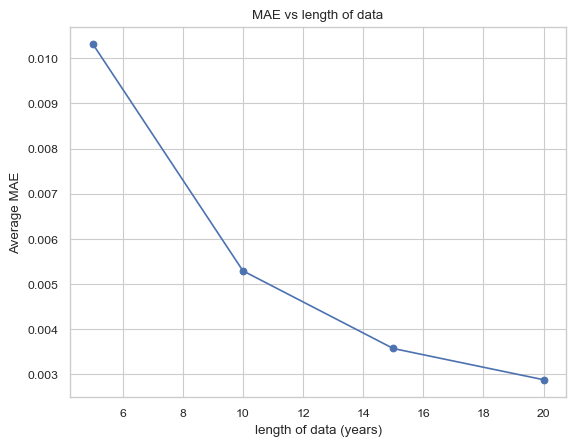

In [307]:
# assess start date
start_dates = ['2017-01-01','2012-01-01','2007-01-01', '2002-01-01']
years = [5,10,15,20]
results = []
num_experiments = 5
stock_symbol = 'AAPL'
end_date = '2022-12-31'

# Read the config file
configs = json.load(open(f'config_lstm_1.json', 'r'))

for i, start_date in enumerate(start_dates):
    print(f"Training with {years[i]} years data")

    preprocessor = StockDataPreprocessor(stock_symbol, start_date, end_date)
    preprocessor.process()
    
    stock_data = preprocessor.stock_data

    predictor = StockPricePredictor(stock_data, configs)

    mae_scores = []
    for j in range(num_experiments):
        # Preprocess the data
        X, y = predictor.preprocess_data()

        # Split the data into training and testing datasets
        X_train, X_test, y_train, y_test = predictor.split_data(X, y, 1 - configs['data']['train_test_split'])
         
        # Train the model and make predictions
        mae = predictor.k_fold_cross_validation(X, y)
        mae_scores.append(mae)

    average_mae = np.mean(mae_scores)
    # Store the results
    results.append({
        'years': years[i],
        'mae': average_mae
    })

# Find the best configuration
best_config = min(results, key=lambda x: x['mae'])
print(f"Best configuration: length of data: {best_config['years']} years, Avg MAE: {best_config['mae']}")
# Plot the MAE vs years of data
years = [result['years'] for result in results]
mae_values = [result['mae'] for result in results]

plt.plot(years, mae_values)
plt.scatter(years, mae_values)
plt.xlabel('length of data (years)')
plt.ylabel('Average MAE')
plt.title('MAE vs length of data')
plt.savefig('lengthofdata.png', dpi=600)
plt.show()